Question 2

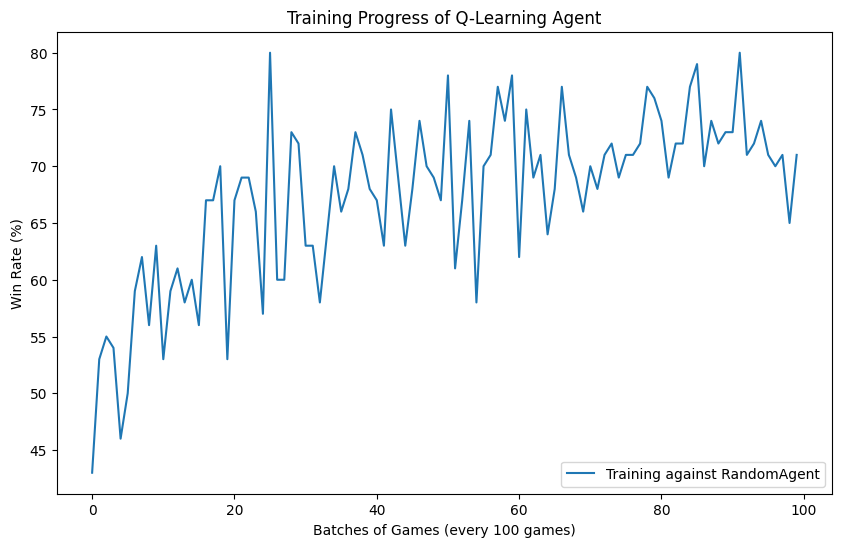

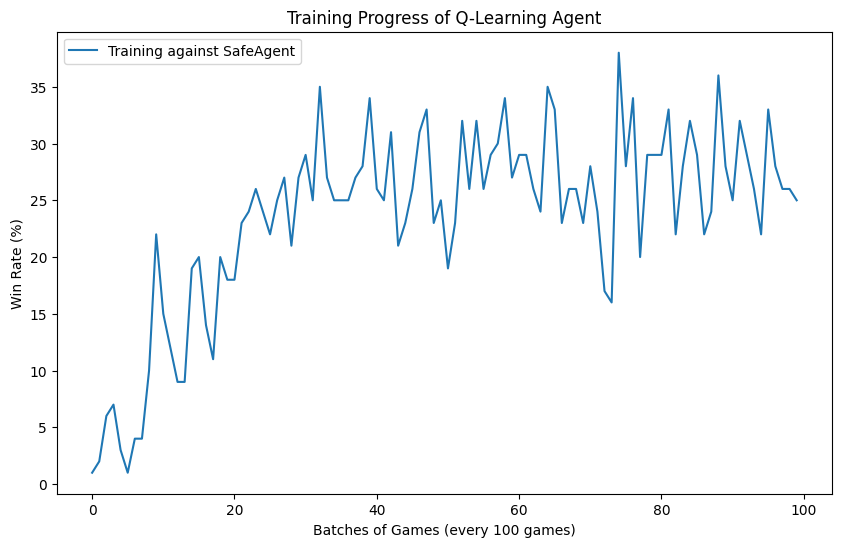

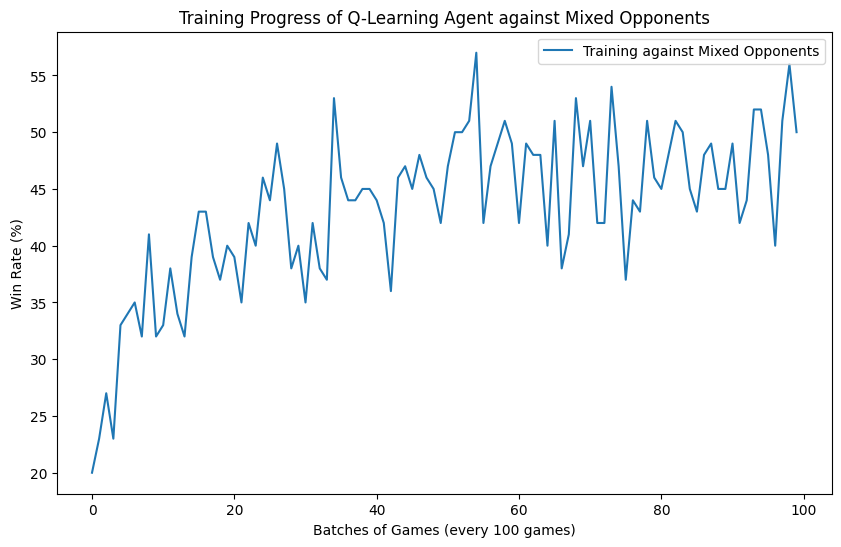

Results of Training Against Random Opponent:
Wins: 93, Draws: 57, Losses: 850
Results of Training Against Safe Opponent:
Wins: 636, Draws: 99, Losses: 265
Results of Training with Mixed Opponents:
Random Opponent - Wins: 779, Draws: 46, Losses: 175
Safe Opponent - Wins: 176, Draws: 38, Losses: 786


In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9
        self.agent_symbol = 'X'
        self.opponent_symbol = 'O'
        self.current_turn = self.agent_symbol if random.choice([True, False]) else self.opponent_symbol

    def print_board(self):
        for row in range(3):
            print("|".join(self.board[row * 3: (row + 1) * 3]))
            if row < 2:
                print("-----")

    def is_valid_move(self, position):
        return 0 <= position < 9 and self.board[position] == ' '

    def make_move(self, position, symbol):
        if self.is_valid_move(position):
            self.board[position] = symbol
            return True
        return False

    def check_winner(self):
        winning_combinations = [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                                (0, 3, 6), (1, 4, 7), (2, 5, 8),
                                (0, 4, 8), (2, 4, 6)]
        for combo in winning_combinations:
            if self.board[combo[0]] == self.board[combo[1]] == self.board[combo[2]] != ' ':
                return self.board[combo[0]]
        return None

    def is_board_full(self):
        return ' ' not in self.board

    def reset_board(self):
        self.board = [' '] * 9
        self.current_turn = self.agent_symbol if random.choice([True, False]) else self.opponent_symbol

    @staticmethod
    def check_winner_static(board):
        winning_combinations = [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                                (0, 3, 6), (1, 4, 7), (2, 5, 8),
                                (0, 4, 8), (2, 4, 6)]
        for combo in winning_combinations:
            if board[combo[0]] == board[combo[1]] == board[combo[2]] != ' ':
                return board[combo[0]]
        return None


class QLearningAgent:
    def __init__(self, agent_symbol='X', opponent_symbol='O', alpha=0.5, gamma=0.9, epsilon=0.1):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.agent_symbol = agent_symbol
        self.opponent_symbol = opponent_symbol

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, available_actions):
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        else:
            q_values = [self.get_q_value(state, action) for action in available_actions]
            max_q = max(q_values)
            best_actions = [action for action, q in zip(available_actions, q_values) if q == max_q]
            return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state, next_available_actions):
        max_future_q = max([self.get_q_value(next_state, a) for a in next_available_actions], default=0)
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[(state, action)] = new_q


class RandomAgent:
    def choose_action(self, available_actions):
        return random.choice(available_actions)

class SafeAgent:
    def choose_action(self, board, available_actions, symbol, opponent_symbol):
        for action in available_actions:
            board_copy = board[:]
            board_copy[action] = symbol
            if TicTacToe.check_winner_static(board_copy) == symbol:
                return action
        for action in available_actions:
            board_copy = board[:]
            board_copy[action] = opponent_symbol
            if TicTacToe.check_winner_static(board_copy) == opponent_symbol:
                return action
        return random.choice(available_actions)


def play_game(agent, opponent, environment):
    state = ''.join(environment.board)
    available_actions = [i for i in range(9) if environment.is_valid_move(i)]

    while not environment.is_board_full() and environment.check_winner() is None:
        if environment.current_turn == agent.agent_symbol:
            action = agent.choose_action(state, available_actions)
            environment.make_move(action, agent.agent_symbol)
            next_state = ''.join(environment.board)
            reward = 1 if environment.check_winner() == agent.agent_symbol else 0
            next_available_actions = [i for i in range(9) if environment.is_valid_move(i)]
            agent.update_q_value(state, action, reward, next_state, next_available_actions)
            state = next_state
        else:
            if isinstance(opponent, RandomAgent):
                action = opponent.choose_action(available_actions)
            elif isinstance(opponent, SafeAgent):
                action = opponent.choose_action(environment.board, available_actions, environment.opponent_symbol, agent.agent_symbol)
            environment.make_move(action, environment.opponent_symbol)

        environment.current_turn = agent.agent_symbol if environment.current_turn == environment.opponent_symbol else environment.opponent_symbol
        available_actions = [i for i in range(9) if environment.is_valid_move(i)]

    winner = environment.check_winner()
    reward = 1 if winner == agent.agent_symbol else -1 if winner == environment.opponent_symbol else 0
    return reward


def evaluate_agent(agent, opponent, games=1000):
    env = TicTacToe()
    wins, draws, losses = 0, 0, 0

    for _ in range(games):
        env.reset_board()
        result = play_game(agent, opponent, env)
        if result == 1:
            wins += 1
        elif result == 0:
            draws += 1
        else:
            losses += 1

    return wins, draws, losses


def train_and_evaluate(agent, training_opponent, test_opponents, games=10000):
    win_rates = []  
    wins = 0  
    for game in range(games):
        result = play_game(agent, training_opponent, TicTacToe())
        if result == 1:
            wins += 1
        
        
        if (game + 1) % 100 == 0:
            win_rate = (wins / 100) * 100
            win_rates.append(win_rate)
            wins = 0  

    results = {}
    for test_opponent in test_opponents:
        wins, draws, losses = evaluate_agent(agent, test_opponent)
        results[type(test_opponent).__name__] = {'Wins': wins, 'Draws': draws, 'Losses': losses}
    
    plot_training_progress(win_rates, type(training_opponent).__name__)
    
    return results

def plot_training_progress(win_rates, opponent_type):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(win_rates)), win_rates, label=f'Training against {opponent_type}')
    plt.xlabel('Batches of Games (every 100 games)')
    plt.ylabel('Win Rate (%)')
    plt.title('Training Progress of Q-Learning Agent')
    plt.legend()
    plt.show()


def train_and_evaluate_mixed(agent, games=10000):
    win_rates = []  
    wins = 0  
    for game in range(games):
        opponent = random.choice([RandomAgent(), SafeAgent()])  
        result = play_game(agent, opponent, TicTacToe())
        if result == 1:
            wins += 1
        

        if (game + 1) % 100 == 0:
            win_rate = (wins / 100) * 100
            win_rates.append(win_rate)
            wins = 0  

    return win_rates


def plot_mixed_training_progress(win_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(win_rates)), win_rates, label='Training against Mixed Opponents')
    plt.xlabel('Batches of Games (every 100 games)')
    plt.ylabel('Win Rate (%)')
    plt.title('Training Progress of Q-Learning Agent against Mixed Opponents')
    plt.legend()
    plt.show()


q_agent_random = QLearningAgent()
q_agent_safe = QLearningAgent()
q_agent_mixed = QLearningAgent()


random_opponent = RandomAgent()
safe_opponent = SafeAgent()


results_random_training = train_and_evaluate(q_agent_random, random_opponent, [safe_opponent], games=10000)
results_safe_training = train_and_evaluate(q_agent_safe, safe_opponent, [random_opponent], games=10000)




mixed_win_rates = train_and_evaluate_mixed(q_agent_mixed)

for _ in range(10000):
    opponent = random.choice([random_opponent, safe_opponent])
    play_game(q_agent_mixed, opponent, TicTacToe())
results_mixed_training = {'Random Opponent': evaluate_agent(q_agent_mixed, random_opponent),
                          'Safe Opponent': evaluate_agent(q_agent_mixed, safe_opponent)}


plot_mixed_training_progress(mixed_win_rates)


print("Results of Training Against Random Opponent:")
print(f"Wins: {results_random_training['SafeAgent']['Wins']}, Draws: {results_random_training['SafeAgent']['Draws']}, Losses: {results_random_training['SafeAgent']['Losses']}")
print("Results of Training Against Safe Opponent:")
print(f"Wins: {results_safe_training['RandomAgent']['Wins']}, Draws: {results_safe_training['RandomAgent']['Draws']}, Losses: {results_safe_training['RandomAgent']['Losses']}")
print("Results of Training with Mixed Opponents:")
print(f"Random Opponent - Wins: {results_mixed_training['Random Opponent'][0]}, Draws: {results_mixed_training['Random Opponent'][1]}, Losses: {results_mixed_training['Random Opponent'][2]}")
print(f"Safe Opponent - Wins: {results_mixed_training['Safe Opponent'][0]}, Draws: {results_mixed_training['Safe Opponent'][1]}, Losses: {results_mixed_training['Safe Opponent'][2]}")



